In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
    ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from datetime import datetime
import warnings

In [3]:
from pylab import rcParams

rcParams['figure.figsize'] = 16,9

# **Input Data**

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Credit_Scoring/Test/13.12/data_filled.csv')

In [17]:
df

,Unnamed: 0,LoanBriefID,LoanAmount,LoanTime,IsReMarketing,ProvinceId,Gender,Age,JobId,ImcomeType,IsMerried,NumberBaby,RelationshipType,LivingWith,RateTypeId,ProductId,ResidentType,LoanAmountExpertiseAI,NumberCall,score,label_result
0,0,1095199,30000000,12,0,1,0.0,31,123.0,1.0,1.0,1.0,1.0,1.0,10,5,6,48800000.0,0.0,1.0,True
1,1,950035,12000000,6,1,1,0.0,30,123.0,5.0,1.0,2.0,1.0,3.0,10,2,4,13600000.0,1.0,0.6,False
2,2,975972,10000000,9,1,1,0.0,29,123.0,1.0,1.0,1.0,1.0,2.0,10,5,4,24000000.0,1.0,0.9,True
3,3,943144,5000000,9,1,79,0.0,25,123.0,5.0,0.0,0.0,2.0,1.0,10,2,4,0.0,8.0,0.9,True
4,4,1015972,16000000,9,0,1,0.0,28,123.0,1.0,0.0,1.0,15.0,0.0,10,2,7,24100000.0,0.0,0.4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10195,10195,1801710,12000000,12,0,26,0.0,35,123.0,5.0,1.0,2.0,1.0,0.0,13,2,14,17900000.0,0.0,0.9,True
10196,10196,1803670,10000000,12,0,1,0.0,34,126.0,1.0,1.0,3.0,9.0,1.0,13,5,14,28050000.0,0.0,0.9,True
10197,10197,1800734,10000000,12,0,79,0.0,31,123.0,1.0,0.0,0.0,4.0,0.0,13,2,14,33400000.0,0.0,0.9,True
10198,10198,1751348,7000000,12,0,1,0.0,35,126.0,1.0,1.0,2.0,1.0,2.0,13,2,15,10300000.0,0.0,0.7,True


# **Process data**

In [5]:
features = ['LoanAmount', 'LoanTime', 'IsReMarketing',
       'ProvinceId', 'Gender', 'Age', 'JobId', 'ImcomeType', 'IsMerried',
       'NumberBaby', 'RelationshipType', 'LivingWith', 'RateTypeId',
       'ProductId', 'ResidentType', 'LoanAmountExpertiseAI', 'NumberCall']

In [6]:
X = df[features]
Y = df['label_result']

In [7]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=42)

# **Train model**

In [8]:
# Train Model

# soft voting
clf1 = RandomForestClassifier(n_estimators=200, class_weight={0: 100, 1: 1})
clf2 = GradientBoostingClassifier(n_estimators=1000, max_depth=7)
clf3 = ExtraTreesClassifier(n_estimators=1000, class_weight={0: 100, 1: 1})
clf4 = XGBClassifier(n_estimators=1000, max_depth=5, learning_rate=0.01)
pos_clf = VotingClassifier(estimators=[('pos', clf1), ('gb', clf2),
                                        ('et', clf3), ('xgb', clf4)],
                            voting='soft',
                            weights=[1, 2, 1, 1])
pos_clf.fit(np.array(X_train), np.array(y_train))

# LightGBM
neg_clf = LGBMClassifier(n_estimators=1000, objective='binary',
                          class_weight={0:25, 1:1}, learning_rate=0.01,
                          boosting_type='dart')
neg_clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='dart', class_weight={0: 25, 1: 1},
               learning_rate=0.01, n_estimators=1000, objective='binary')

**Predict**

In [9]:
pos_clf = pos_clf.predict_proba(np.array(X_test))
##
neg_clf = neg_clf.predict_proba(np.array(X_test))

**Config**

In [10]:
MODEL = {'weights' : {'pos':0.5, 'neg':0.5},
         'probs' : {'pos':0.845, 'neg':0.9},
         'probs_cfn_certain' : {'pos':0.8, 'neg': 0.95},
         'probs_cfn' : {'pos':0.65, 'neg':0.95}}

# **Process problem**

In [12]:
y =[]
for i in range(len(X_test)):
  pos = pos_clf[i]
  neg = neg_clf[i]
  if pos[1] >= MODEL['probs']['pos']:
    y.append((1, pos[1], 'pos'))
  elif neg[0] >= MODEL['probs']['neg']:  
    y.append((0, neg[0], 'neg'))
  else: 
    merge = pos * MODEL['weights']['pos'] + neg*MODEL['weights']['neg']
    label = np.argmax(merge)
    if label == 1 and merge[label] >= MODEL['probs']['pos']:
      merge[label] = MODEL['probs']['pos']
    elif label == 0 and MODEL['probs']['neg']:
      merge[label] = MODEL['probs']['neg']

    if label == 1 and merge[label] >= MODEL['probs_cfn_certain']['pos']:
      y.append((np.argmax(merge), merge[label], 'special_confusion'))
    elif label == 0 and merge[label] >= MODEL['probs_cfn_certain']['neg']:
      y.append((np.argmax(merge), merge[label], 'special_confusion'))
    else: # not certain
      y.append((np.argmax(merge), merge[label], 'confuse'))
print(y)

[(1, 0.9136001627247137, 'pos'), (1, 0.9071759948809148, 'pos'), (1, 0.964498606769245, 'pos'), (1, 0.9872907314902619, 'pos'), (1, 0.96587053498037, 'pos'), (1, 0.9641937700837824, 'pos'), (1, 0.9184930312402816, 'pos'), (1, 0.9584867721567327, 'pos'), (1, 0.9405755966536073, 'pos'), (1, 0.9760223402980271, 'pos'), (1, 0.9598170386690889, 'pos'), (0, 0.908491010110915, 'neg'), (1, 0.945168969032786, 'pos'), (1, 0.9066360624353061, 'pos'), (1, 0.9404727458912705, 'pos'), (0, 0.947115643211946, 'neg'), (1, 0.8526355091625225, 'pos'), (1, 0.9534239936233055, 'pos'), (1, 0.9280404483155292, 'pos'), (1, 0.9811026148800817, 'pos'), (0, 0.9025179869918046, 'neg'), (1, 0.9645163037423782, 'pos'), (0, 0.9, 'confuse'), (1, 0.9489288374753173, 'pos'), (1, 0.9561156292942741, 'pos'), (1, 0.9531274191936697, 'pos'), (0, 0.9, 'confuse'), (1, 0.9323792673489105, 'pos'), (0, 0.947115643211946, 'neg'), (0, 0.947115643211946, 'neg'), (1, 0.9556444860930371, 'pos'), (1, 0.8475754058353069, 'pos'), (1, 0

In [13]:
new_y_pred = []
new_y_pred_1 = []
new_y_pred_2 = []
new_y_test = []
for i, p in enumerate(y):
  if str(p[2]) == str('confuse'):
    continue 
  # print(p)
  # print(i)
  new_y_pred.append(p[0])
  new_y_pred_1.append(p[1])
  new_y_pred_2.append(p[2])
  new_y_test.append(y_test.values[i])

In [14]:
y_pred_score = []
# Tính score
for i in range(0, len(new_y_pred)):
  if str(new_y_pred_2[i]) == str('pos'):
    y_pred_score.append(new_y_pred_1[i]*1000)
  elif str(new_y_pred_2[i]) == str('neg'):
    y_pred_score.append((1 - new_y_pred_1[i])*1000)

**Calulator score in station "confuse"**

In [18]:
y_pred_score_confuse = []
for i in range(0,len(y)):
  if str(y[i][2]) == str('confuse'):
    if y[i][0] == 1:
      y_pred_score_confuse.append(y[i][1] * 1000)
    else:
       y_pred_score_confuse.append((1 - y[i][1]) * 1000)

In [ ]:
y_pred_score_confuse

**Plot distribute score**

In [21]:
y_score_total = []

for i in range(0, len(y_pred_score_confuse)):
  y_score_total.append(y_pred_score_confuse[i])

for i in range(0, len(y_pred_score)):
  y_score_total.append(y_pred_score[i])

In [22]:
y_score_total_DF = pd.DataFrame(y_score_total, columns=['Score'])

In [23]:
y_score_total_DF_1 = y_score_total_DF[0:3060]
y_score_total_DF_1

,Score
0,100.000000
1,100.000000
2,100.000000
3,100.000000
4,100.000000
...,...
3055,935.607901
3056,987.178297
3057,953.097682
3058,61.827822


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


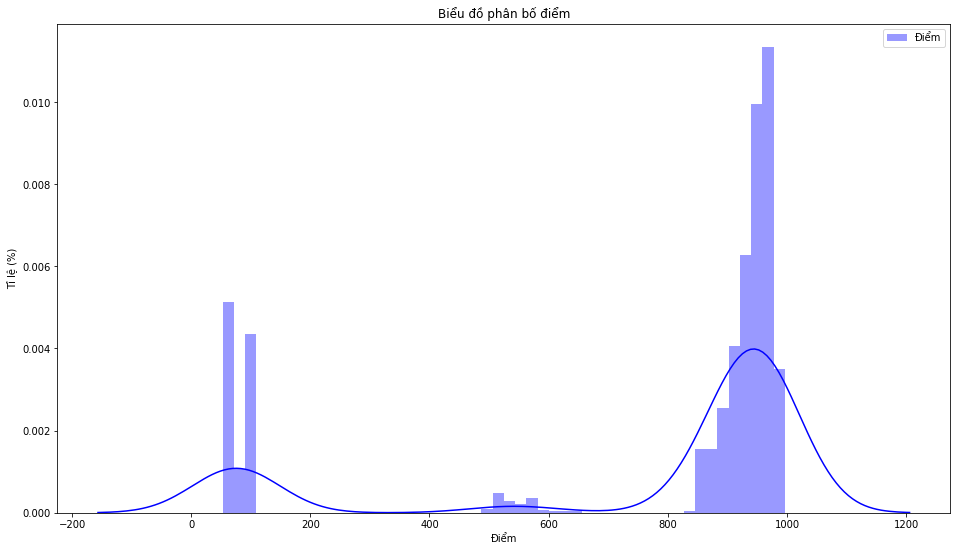

In [24]:
sns.distplot(y_score_total_DF_1['Score'], color="blue", label="Điểm")
plt.title('Biểu đồ phân bố điểm')
plt.xlabel("Điểm")
plt.ylabel("Tỉ lệ (%)")
plt.legend();

**evaluate model**

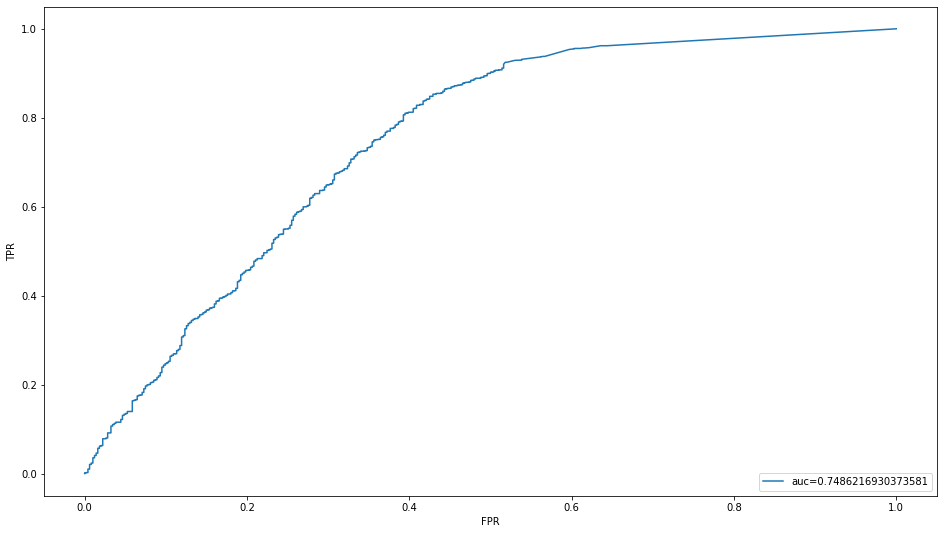

In [15]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(new_y_test, y_pred_score)
auc = metrics.roc_auc_score(new_y_test, y_pred_score)
plt.plot(fpr, tpr, label="auc=" + str(auc))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(loc=4)
plt.show()

In [16]:
print("Các chỉ số đánh giá mức độ hiệu quả của mô hình: ")
#Accuracy
print("1. Accuracy:",accuracy_score(new_y_test, new_y_pred))
# confusion_matrix
print('2. confusion_matrix:')
print(confusion_matrix(new_y_test, new_y_pred))
# recall_score
print('3. recall_score: ', recall_score(new_y_test, new_y_pred))
# precision_score
print('4. precision_score: ', precision_score(new_y_test, new_y_pred))
# f1_score
print('5. f1_score: ', f1_score(new_y_test, new_y_pred))

Các chỉ số đánh giá mức độ hiệu quả của mô hình: 
1. Accuracy: 0.8428057553956835
2. confusion_matrix:
[[ 239  255]
 [ 182 2104]]
3. recall_score:  0.9203849518810149
4. precision_score:  0.8919033488766427
5. f1_score:  0.9059203444564048
